In [1]:
import tensorflow as tf
try: #If running in colab 
    import google.colab
    IN_COLAB = True 
except:
    IN_COLAB = False
if (not tf.__version__.startswith('2')): #Checking if tf 2.0 is installed
    if IN_COLAB: #If running in colab install tf 2.0
        !pip install tensorflow-gpu==2.0.0-rc0
        !pip install tensorflow-probability==0.8.0-rc0
    print('Please install tensorflow 2.0 to run this notebook')
print('Tensorflow version: ',tf.__version__, ' running in colab?: ', IN_COLAB)

Tensorflow version:  2.0.0-rc0  running in colab?:  False


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow_probability as tfp


%matplotlib inline
plt.style.use('default')

tfd = tfp.distributions
tfb = tfp.bijectors
print("TFP Version", tfp.__version__)
print("TF  Version",tf.__version__)
np.random.seed(1)
tf.random.set_seed(1)

TFP Version 0.8.0-rc0
TF  Version 2.0.0-rc0


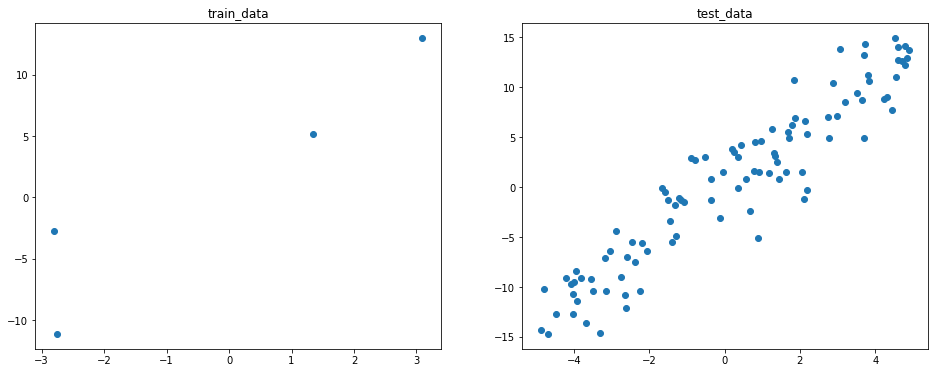

In [3]:
sigma = 3
N_train = 4
N_test  = 100
def get_data():
    x=np.arange(-5,5,0.01)#x range
    noise=np.random.normal(loc=0,scale=sigma,size=len(x))# const var
    y=2.7*x+noise #y linear model with const var
    y=y.reshape((len(y),1))
    x=x.reshape((len(x),1))
    train_idx=np.random.choice(range(0,len(x)),N_train,replace=False)# sample 4 trainpoints
    test_range=np.delete(range(0,len(x)),train_idx)
    test_idx=np.random.choice(test_range,N_test,replace=False)# sample 100 testpoints, without the 4 from train
    return x[train_idx], y[train_idx], x[test_idx], y[test_idx]
    
x_train, y_train, x_test, y_test = get_data()

plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.scatter(x_train, y_train)
plt.title("train_data")
plt.subplot(1,2,2)
plt.scatter(x_test, y_test)
plt.title("test_data")
plt.show()

In [4]:
from sklearn.linear_model import LinearRegression
model_skl = LinearRegression()

def get_nll_lin(x_train, y_train,x_test,y_test):
    res = model_skl.fit(x_train, y_train)
    r2 = (y_test - model_skl.predict(x_test))**2
    nll = N_test*np.log(np.sqrt(2*np.pi*sigma**2)) + np.sum((r2/(2*sigma**2)))
    return nll,res.coef_,res.intercept_

### Bayes

In [5]:
def posterior(Phi, t, alpha, beta, return_inverse=False):
    """Computes mean and covariance matrix of the posterior distribution."""
    S_N_inv = alpha * np.eye(Phi.shape[1]) + beta * Phi.T.dot(Phi)
    S_N = np.linalg.inv(S_N_inv)
    m_N = beta * S_N.dot(Phi.T).dot(t)

    if return_inverse:
        return m_N, S_N, S_N_inv
    else:
        return m_N, S_N


def posterior_predictive(Phi_test, m_N, S_N, beta):
    """Computes mean and variances of the posterior predictive distribution."""
    y = Phi_test.dot(m_N)
    # Only compute variances (diagonal elements of covariance matrix)
    y_var = 1 / beta + np.sum(Phi_test.dot(S_N) * Phi_test, axis=1)
    
    return y, y_var

def expand(x, bf, bf_args=None):
    if bf_args is None:
        return np.concatenate([np.ones(x.shape), bf(x)], axis=1)
    else:
        return np.concatenate([np.ones(x.shape)] + [bf(x, bf_arg) for bf_arg in bf_args], axis=1)

def identity_basis_function(x):
    return x

In [6]:
def get_nll_bayes(x_train, y_train,x_test, y_test):
    beta =  1.0 / sigma**2
    alpha = 1.0 #Prior

    # Mean and covariance matrix of posterior
    Phi = expand(x_train, identity_basis_function) #Designmatrix
    m, S = posterior(Phi, y_train, alpha, beta)
    Phi_test = expand(x_test, identity_basis_function)
    # Mean and variances of posterior predictive 
    yt, yt_var = posterior_predictive(Phi_test, m, S, beta)
    nll = 0
    for i in range(N_test):
        n = tfd.Normal(loc=yt[i], scale=np.sqrt(yt_var[i])) #TODO make for all N_train at once
        nll += n.log_prob(y_test[i])
    return -nll,m[1],m[0]


In [7]:
N_train = 100 #Large number Bayes should be similar to MaxLike
x_train, y_train, x_test, y_test = get_data()

nll,a_ml,b_ml = get_nll_lin(x_train, y_train, x_test, y_test)
print('Coefficients a_ml: ', a_ml[0], 'Coefficients b_ml', b_ml, ' nll (per data point)', nll/N_test)

nll,a_ml,b_ml = get_nll_bayes(x_train, y_train, x_test, y_test)
print('Coefficients a_bayes: ', a_ml[0], 'Coefficients b_ml', b_ml, ' nll (per data point)', nll/N_test)

Coefficients a_ml:  [2.54714062] Coefficients b_ml [0.53985247]  nll (per data point) 2.4814315448019544
Coefficients a_bayes:  2.5171243658426117 Coefficients b_ml [0.49328651]  nll (per data point) tf.Tensor([2.48321624], shape=(1,), dtype=float64)


In [8]:
N_train = 4 #Small Bayes
x_train, y_train, x_test, y_test = get_data()

nll,a_ml,b_ml = get_nll_lin(x_train, y_train, x_test, y_test)
print('Coefficients a_ml: ', a_ml[0], 'Coefficients b_ml', b_ml, ' nll (per data point)', nll/N_test)

nll,a_ml,b_ml = get_nll_bayes(x_train, y_train, x_test, y_test)
print('Coefficients a_bayes: ', a_ml[0], 'Coefficients b_ml', b_ml, ' nll (per data point)', nll/N_test)

Coefficients a_ml:  [3.31185201] Coefficients b_ml [-0.48170139]  nll (per data point) 2.731037956960999
Coefficients a_bayes:  1.8095932661150993 Coefficients b_ml [-0.34235386]  nll (per data point) tf.Tensor([2.99381802], shape=(1,), dtype=float64)


In [9]:
N_train = 4

runs = 100
nll_bayes = np.zeros(runs)
nll_max_like = np.zeros(runs)
for i in range(runs):
    x_train, y_train, x_test, y_test = get_data()
    m,_,_= get_nll_lin(x_train, y_train, x_test, y_test)
    nll_max_like[i] = m
    b ,_,_ = get_nll_bayes(x_train, y_train, x_test, y_test)
    nll_bayes[i] = b

Means  277.52757920461846 369.22127207394334


(269.0087899282315, 273.9339284936441)

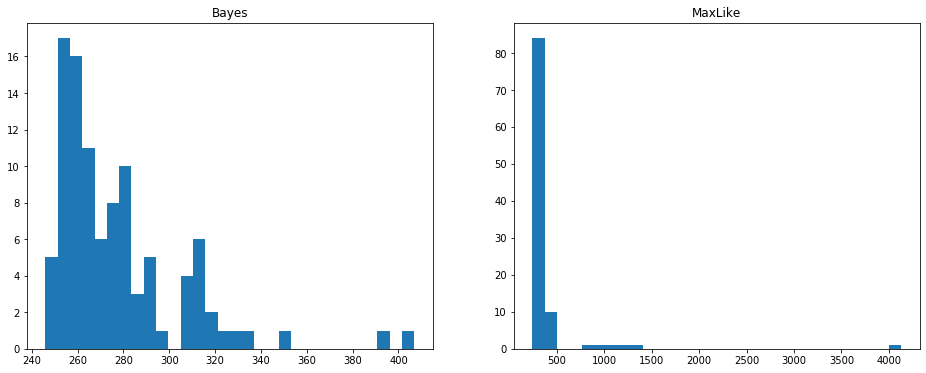

In [10]:
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.hist(nll_bayes,30)
plt.title('Bayes')
plt.subplot(1,2,2)
plt.hist(nll_max_like,30)
plt.title('MaxLike')
print('Means ',np.mean(nll_bayes),np.mean(nll_max_like))
np.median(nll_bayes), np.median(nll_max_like)